```{index} single: Pyomo; block
```
```{index} single: Pyomo; kernel library
```
```{index} single: conic optimization; exponential cones
```
```{index} single: solver; mosek
```
```{index} single: application; portfolio
```

# Extra material: Optimal Growth Portfolios with Risk Aversion

Among the reasons why Kelly was neglected by investors were high profile critiques by the most famous economist of the 20th Century, Paul Samuelson. Samuelson objected on several grounds, among them is a lack of risk aversion that results in large bets and risky short term behavior, and that Kelly's result is applicable to only one of many utility functions that describe investor preferences. The controversy didn't end there, however, as other academic economists, including Harry Markowitz, and practitioners found ways to adapt the Kelly criterion to investment funds.

This notebook presents solutions to Kelly's problem for optimal growth portfolios using exponential cones. A significant feature of this notebook is the the inclusion of a risk constraints recently proposed by Boyd and coworkers. These notes are based on recent papers such as Cajas (2021), Busseti, Ryu and Boyd (2016), Fu, Narasimhan, and Boyd (2017). Additional bibliographic notes are provided at the end of the notebook.

In [1]:
# install Pyomo and solvers
import sys

SOLVER_CONIC = "mosek_direct"

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre >/dev/null 2>/dev/null
    !idaes get-extensions --to ./bin 
    os.environ['PATH'] += ':bin'
    
    SOLVER_CONIC = "ipopt"

## Financial Data

We begin by reading historical prices for a selected set of trading symbols using [yfinance](https://github.com/ranaroussi/yfinance). 

While it would be interesting to include an international selection of financial indices and assets, differences in trading and bank holidays would involve more elaborate coding. For that reason, the following cell has been restricted to indices and assets trading in U.S. markets.

In [2]:
# run this cell to install yfinance
!pip install yfinance --upgrade -q

In [3]:
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import datetime
import yfinance as yf

# symbols as used by Yahoo Finance
symbols = {
    # selected indices
    '^GSPC': "S&P 500",
    '^IXIC': "Nasdaq",
    '^DJI': "Dow Jones Industrial",
    '^RUT': "Russell 2000",
    # selected stocks
    'AXP': "American Express",
    'AMGN': "Amgen",
    'AAPL': "Apple",
    'BA': "Boeing",
    'CAT': "Caterpillar",
    'CVX': "Chevron",
    'JPM': "JPMorgan Chase",
    'MCD': "McDonald's",
    'MMM': "3 M",
    'MSFT': "Microsoft",
    'PG': "Proctor & Gamble",
    'XOM': "ExxonMobil",
}

# years of testing and training data
n_test = 1
n_train = 2

# get today's date
today = datetime.datetime.today().date()

# training data dates
end = today - datetime.timedelta(int(n_test*365))
start = end - datetime.timedelta(int((n_test + n_train)*365))

# get training data
S = yf.download(list(symbols.keys()), start=start, end=end)["Adj Close"]

# compute gross returns
R = S/S.shift(1)
R.dropna(inplace=True)

[*********************100%***********************]  16 of 16 completed


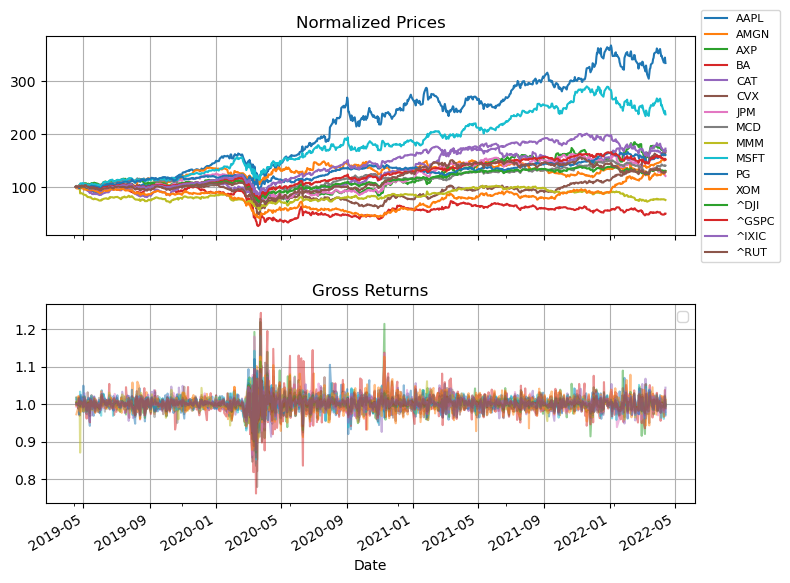

In [4]:
# plot
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

S.divide(S.iloc[0]/100).plot(ax=ax[0], grid=True, title="Normalized Prices")
ax[0].legend(loc="center left", bbox_to_anchor=(1.0, 0.5), prop={'size':8})

R.plot(ax=ax[1], grid=True, title="Gross Returns", alpha=0.5).legend([])

fig.tight_layout()


## Portfolio Design for Optimal Growth

### Model

Here we are examining a set $N$ of financial assets trading in efficient markets. The historical record consists of a matrix $R \in \mathbb{R}^{T\times N}$ of gross returns where $T$ is the number of observations. 

The weights $w_n \geq 0$ for $n\in N$ denote the fraction of the portfolio invested in asset $n$. Any portion of the portfolio not invested in traded assets is assumed to have a gross risk-free return $R_f = 1 + r_f$, where $r_f$ is the return on a risk-free asset.

Assuming the gross returns are independent and identically distributed random variables, and the historical data set is representative of future returns, the investment model becomes

$$
\begin{align}
\max_{w_n \geq 0}\quad & \frac{1}{T} \sum_{t\in T} \log(R_t) \\
\text{s.t.}\quad \\
& R_t = R_f + \sum_{n\in N} w_n (R_{t, n} - R_f) & \forall t\in T\\
\end{align}
$$

Note this formulation allows the sum of weights $\sum_{n\in N} w_n$ to be greater than one. In that case the investor would be investing more than the value of the portfolio in traded assets. In other words the investor would be creating a leveraged portfolio by borrowing money at a rate $R_f$. To incorporate a constraint on the degree of leveraging, we introduce a constraint

$$\sum_{n\in N} w_n \leq E_M$$

where $E_M$ is the "equity multiplier." A value $E_M \leq 1$ restricts the total investment to be less than or equal to the equity available to the investor. A value $E_M > 1$ allows the investor to leverage the available equity by borrowing money at a gross rate $R_f = 1 + r_f$. 

Using techniques demonstrated in other examples, this model can be reformulated with exponential cones.

$$
\begin{align}
\max_{w_n}\quad & \frac{1}{T} \sum_{t\in T} q_t \\
\text{s.t.}\quad 
& (R_f + \sum_{n\in N}w_n (R_{t,n} - R_f), 1, q_t) \in K_{exp} & \forall t \in T \\
& \sum_{n\in N} w_n \leq E_M \\
& w_n \geq 0  & \forall n\in N \\
\end{align} 
$$

For the risk constrained case, we consider a constraint

$$\mathbb{E}[R^{-\lambda}] \leq R_f^{-\lambda}$$

where $\lambda$ is a risk aversion parameter. Assuming the historical returns are equiprobable 

$$\frac{1}{T} \sum_{t\in T} R_t^{-\lambda} \leq R_f^{-\lambda}$$

The risk constraint is satisfied for any $w_n$ if the risk aversion parameter $\lambda=0$. For any value $\lambda > 0$ the risk constraint has a feasible solution $w_n=0$ for all $n \in N$. Recasting as a sum of exponentials,

$$\frac{1}{T} \sum_{t\in T} e^{- \lambda\log(R_t)} \leq R_f^{-\lambda}$$

Using the $q_t \leq \log(R_t)$ as used in the examples above, and $u_t \geq e^{- \lambda q_t}$, we get the risk constrained model optimal log growth. 

Given a risk-free rate of return $R_f$, a maximum equity multiplier $E_M$, and value $\lambda \geq 0$ for the risk aversion, risk constrained Kelly portfolio is given the solution to

$$
\begin{align}
\max_{w_n, q_t, u_t}\quad & \frac{1}{T} \sum_{t\in T} q_t \\
\text{s.t.}\quad 
& \frac{1}{T} \sum_{t\in T} u_t \leq R_f^{-\lambda} \\
& (u_t, 1, \lambda q_t) \in K_{exp} & \forall t\in T \\
& (R_f + \sum_{n\in N}w_n (R_{t,n} - R_f), 1, q_t) \in K_{exp} & \forall t \in T \\
& \sum_{n\in N} w_n \leq E_M \\
& w_n \geq 0 & \forall n \in N \\
\end{align}
$$

The following cells demonstrate an implementation of the model using the Pyomo kernel library and Mosek solver.

### Pyomo Implementation

The Pyomo implementation for the risk-constrained Kelly portfolio accepts three parameters, the risk-free gross returns $R_f$, the maximum equity multiplier, and the risk-aversion parameter.


Risk Free Return = 0.00
Equity Multiplier Limit = 1.00000
Risk Aversion = 10.00000

Portfolio
AAPL     Apple                              63.30 %
AMGN     Amgen                               0.00 %
AXP      American Express                    0.00 %
BA       Boeing                              0.00 %
CAT      Caterpillar                         8.36 %
CVX      Chevron                             0.00 %
JPM      JPMorgan Chase                      0.00 %
MCD      McDonald's                          0.00 %
MMM      3 M                                 0.00 %
MSFT     Microsoft                           0.00 %
PG       Proctor & Gamble                   12.91 %
XOM      ExxonMobil                          0.00 %
^DJI     Dow Jones Industrial                0.00 %
^GSPC    S&P 500                             0.00 %
^IXIC    Nasdaq                              0.00 %
^RUT     Russell 2000                        0.00 %
         Risk Free                          15.44 %

Annualized return = 

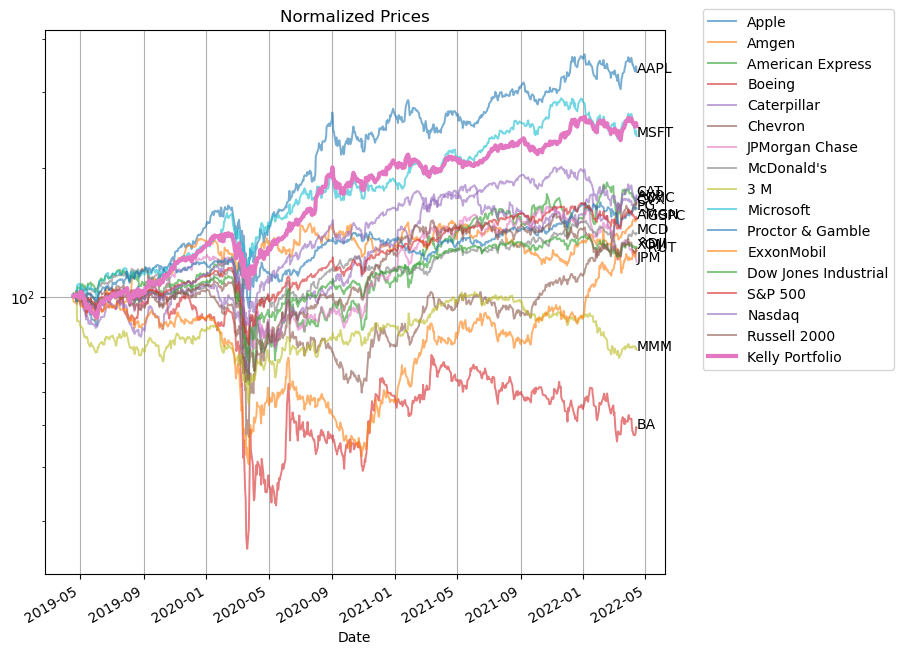

In [5]:
import pyomo.kernel as pmo

def kelly_portfolio(R, Rf=1, EM=1, lambd=0):

    m = pmo.block()
    
    # return parameters with the model
    m.Rf = Rf
    m.EM = EM
    m.lambd = lambd
    
    # index lists
    m.T = R.index
    m.N = R.columns
    
    # decision variables
    m.q = pmo.variable_dict({t: pmo.variable() for t in m.T})
    m.w = pmo.variable_dict({n: pmo.variable(lb=0) for n in m.N})

    # objective
    m.ElogR = pmo.objective(sum(m.q[t] for t in m.T)/len(m.T), sense=pmo.maximize)

    # conic constraints on return
    m.R = pmo.expression_dict({t: pmo.expression(Rf + sum(m.w[n]*(R.loc[t, n] - Rf) for n in m.N)) for t in m.T})
    m.c = pmo.block_dict({t:pmo.conic.primal_exponential.as_domain(m.R[t], 1, m.q[t]) for t in m.T})

    # risk constraints
    m.u = pmo.variable_dict({t: pmo.variable() for t in m.T})
    m.u_sum = pmo.constraint(sum(m.u[t] for t in m.T)/len(m.T) <= Rf**(-lambd))
    m.r = pmo.block_dict({t:pmo.conic.primal_exponential.as_domain(m.u[t], 1, -lambd*m.q[t]) for t in m.T})
    
    # equity multiplier constraint
    m.w_sum = pmo.constraint(sum(m.w[n] for n in m.N) <= EM)

    pmo.SolverFactory(SOLVER_CONIC).solve(m)
    
    return m

def kelly_report(m):
    #print report
    s = f"""
Risk Free Return = {100*(np.exp(252*np.log(m.Rf)) - 1):0.2f}
Equity Multiplier Limit = {m.EM:0.5f}
Risk Aversion = {m.lambd:0.5f}

Portfolio
"""
    s += "\n".join([f"{n:8s} {symbols[n]:30s}  {100*m.w[n]():8.2f} %" for n in m.N])
    s += f"""
{'':8s} {'Risk Free':30s}  {100*(1 - sum(m.w[n]() for n in R.columns)):8.2f} %

Annualized return = {100*(np.exp(252*m.ElogR()) - 1):0.2f} %
"""
    print(s)
    
    df = pd.DataFrame(pd.Series([m.R[t]() for t in m.T]), columns=["Kelly Portfolio"])
    df.index = m.T
    
    fix, ax = plt.subplots(1, 1, figsize=(8, 8))
    S.divide(S.iloc[0]/100).plot(ax=ax, logy=True, grid=True, title="Normalized Prices", alpha=0.6, lw=1.4)
    df.cumprod().multiply(100).plot(ax=ax, lw=3, grid=True)
    ax.legend([symbols[n] for n in m.N] + ["Kelly Portfolio"], bbox_to_anchor=(1.05, 1.05))
    
    d = S.index[-1]
    print(d)
    
    for n in m.N:
        y = 100*S[n].iloc[-1]/S[n].iloc[0]
        print(n, 100*S[n].iloc[-1]/S[n].iloc[0])
        ax.text(d, y, n)

   
# parameter values
Rf = Rf=np.exp(np.log(1.0)/252)
EM = 1
lambd = 10

m = kelly_portfolio(R, Rf, EM, lambd)
kelly_report(m)

In [6]:
S.head()

,AAPL,AMGN,AXP,BA,CAT,CVX,JPM,MCD,MMM,MSFT,PG,XOM,^DJI,^GSPC,^IXIC,^RUT
Date,,,,,,,,,,,,,,,,
2019-04-17,49.149212,161.858185,105.645004,368.677887,129.171402,100.436394,101.196877,174.648224,187.561417,116.863243,96.465317,65.426285,26449.539062,2900.449951,7996.080078,1567.599976
2019-04-18,49.325836,157.422989,107.450493,371.168182,130.518799,100.094002,100.453163,177.656082,188.630020,118.398788,96.647598,65.185249,26559.539062,2905.030029,7998.060059,1565.750000
2019-04-22,49.487949,156.438354,106.183823,366.382935,129.626587,101.797623,100.577118,176.753738,188.337006,118.773064,96.611137,66.607391,26511.050781,2907.969971,8015.270020,1560.040039
2019-04-23,50.201729,159.454315,107.734077,365.259857,129.307938,101.897804,100.701073,177.975113,189.164307,120.385384,94.013809,66.993034,26656.390625,2933.679932,8120.819824,1585.089966
2019-04-24,50.124306,158.159241,107.781349,366.666168,125.393105,98.774574,100.532867,180.135315,188.802399,119.972687,94.496819,65.691429,26597.050781,2927.250000,8102.009766,1588.130005


### Effects of the Risk-Aversion Parameter

In [7]:
lambd = 10**np.linspace(0, 3)

results = [kelly_portfolio(R, Rf=1, EM=1, lambd=_) for _ in lambd]

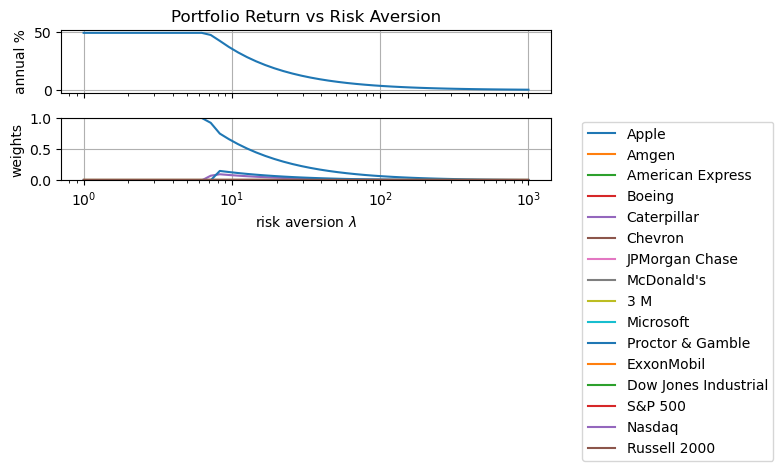

In [8]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(2, 1, figsize=(8, 4), sharex=True)

ax[0].semilogx([m.lambd for m in results], [100*(np.exp(252*m.ElogR()) - 1) for m in results])
ax[0].set_title('Portfolio Return vs Risk Aversion')
ax[0].set_ylabel("annual %")
ax[0].grid(True)

ax[1].semilogx([m.lambd for m in results], [[m.w[n]() for n in R.columns] for m in results])
ax[1].set_ylabel('weights')
ax[1].set_xlabel('risk aversion $\lambda$')
ax[1].legend([symbols[n] for n in m.N], bbox_to_anchor=(1.05, 1.05))
ax[1].grid(True)
ax[1].set_ylim(0, EM)

fig.tight_layout()

### Effects of the Equity Multiplier Parameter

In [9]:
EM = np.linspace(0.0, 2.0)

results = [kelly_portfolio(R, Rf=1, EM=_, lambd=10) for _ in EM]

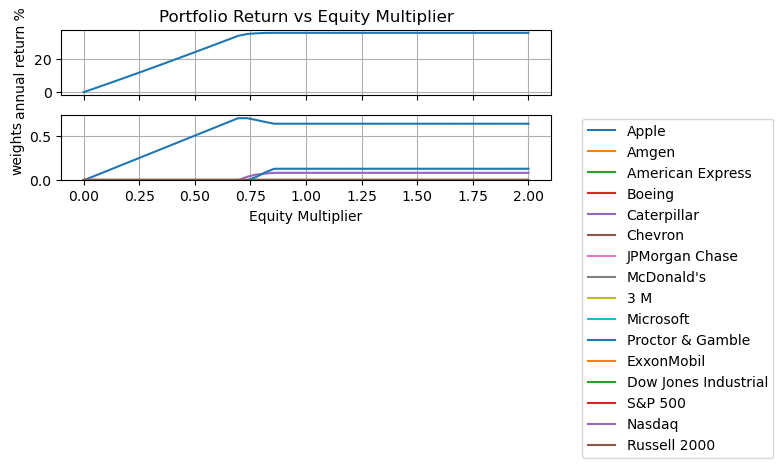

In [10]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(2, 1, figsize=(8, 4), sharex=True)

ax[0].plot([m.EM for m in results], [100*(np.exp(252*m.ElogR()) - 1) for m in results])
ax[0].set_title('Portfolio Return vs Equity Multiplier')
ax[0].set_ylabel("annual return %")
ax[0].grid(True)

ax[1].plot([m.EM for m in results], [[m.w[n]() for n in R.columns] for m in results])
ax[1].set_ylabel('weights')
ax[1].set_xlabel('Equity Multiplier')
ax[1].legend([symbols[n] for n in m.N], bbox_to_anchor=(1.05, 1.05))
ax[1].grid(True)
ax[1].set_ylim(0, )

fig.tight_layout()

### Effect of Risk-free Interest Rate

In [11]:
Rf = np.exp(np.log(1 + np.linspace(0, 0.20))/252)

results = [kelly_portfolio(R, Rf=_, EM=1, lambd=10) for _ in Rf]

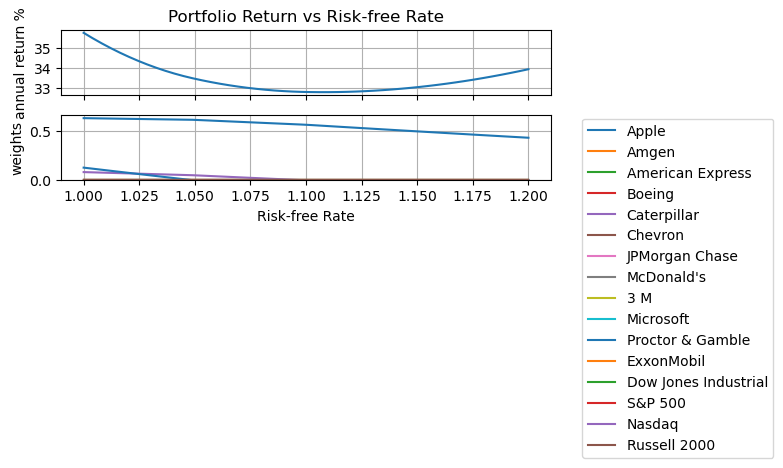

In [12]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(2, 1, figsize=(8, 4), sharex=True)

Rf = np.exp(252*np.log(np.array([_.Rf for _ in results])))
ax[0].plot(Rf, [100*(np.exp(252*m.ElogR()) - 1) for m in results])
ax[0].set_title('Portfolio Return vs Risk-free Rate')
ax[0].set_ylabel("annual return %")
ax[0].grid(True)

ax[1].plot(Rf, [[m.w[n]() for n in R.columns] for m in results])
ax[1].set_ylabel('weights')
ax[1].set_xlabel('Risk-free Rate')
ax[1].legend([symbols[n] for n in m.N], bbox_to_anchor=(1.05, 1.05))
ax[1].grid(True)
ax[1].set_ylim(0, )

fig.tight_layout()

## Extensions

1. The examples cited in this notebook assume knowledge of the probability mass distribution. Recent work by Sun and Boyd (2018) and Hsieh (2022) suggest models for finding investment strategies for cases where the distributions are not perfectly known. They call the "distributional robust Kelly gambling." A useful extension to this notebook would be to demonstrate a robust solution to one or more of the examples.

## Bibliographic Notes

> Thorp, E. O. (2017). A man for all markets: From Las Vegas to wall street, how i beat the dealer and the market. Random House.

> Thorp, E. O. (2008). The Kelly criterion in blackjack sports betting, and the stock market. In Handbook of asset and liability management (pp. 385-428). North-Holland. https://www.palmislandtraders.com/econ136/thorpe_kelly_crit.pdf

> MacLean, L. C., Thorp, E. O., & Ziemba, W. T. (2010). Good and bad properties of the Kelly criterion. Risk, 20(2), 1.  https://www.stat.berkeley.edu/~aldous/157/Papers/Good_Bad_Kelly.pdf

> MacLean, L. C., Thorp, E. O., & Ziemba, W. T. (2011). The Kelly capital growth investment criterion: Theory and practice (Vol. 3). world scientific. https://www.worldscientific.com/worldscibooks/10.1142/7598#t=aboutBook

> Carta, A., & Conversano, C. (2020). Practical Implementation of the Kelly Criterion: Optimal Growth Rate, Number of Trades, and Rebalancing Frequency for Equity Portfolios. Frontiers in Applied Mathematics and Statistics, 6, 577050. https://www.frontiersin.org/articles/10.3389/fams.2020.577050/full

The utility of conic optimization to solve problems involving log growth is more recent. Here are some representative papers.

> Cajas, D. (2021). Kelly Portfolio Optimization: A Disciplined Convex Programming Framework. Available at SSRN 3833617. https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3833617

> Busseti, E., Ryu, E. K., & Boyd, S. (2016). Risk-constrained Kelly gambling. The Journal of Investing, 25(3), 118-134. https://arxiv.org/pdf/1603.06183.pdf

> Fu, A., Narasimhan, B., & Boyd, S. (2017). CVXR: An R package for disciplined convex optimization. arXiv preprint arXiv:1711.07582. https://arxiv.org/abs/1711.07582

> Sun, Q., & Boyd, S. (2018). Distributional robust Kelly gambling. arXiv preprint arXiv: 1812.10371. https://web.stanford.edu/~boyd/papers/pdf/robust_kelly.pdf

The recent work by CH Hsieh extends these concepts in important ways for real-world implementation.

> Hsieh, C. H. (2022). On Solving Robust Log-Optimal Portfolio: A Supporting Hyperplane Approximation Approach. arXiv preprint arXiv:2202.03858. https://arxiv.org/pdf/2202.03858
